In [8]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from fuzzywuzzy import fuzz
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
data=pd.read_csv('quora.csv')

In [10]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [11]:
data.shape

(404290, 6)

In [12]:
# since there is very large number of dataset so we only take some sample of the dataset
df=data.sample(30000,random_state=2)

In [13]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


In [14]:
df.shape

(30000, 6)

In [15]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


## Data Preprocessing and EDA

In [16]:
def preprocess(sentence):
    
    sentence = str(sentence).lower().strip()
    
    # Replace certain special characters with their string equivalents
    sentence = sentence.replace('%', ' percent')
    sentence = sentence.replace('$', ' dollar ')
    sentence = sentence.replace('₹', ' rupee ')
    sentence = sentence.replace('€', ' euro ')
    sentence = sentence.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    sentence = sentence.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    sentence = sentence.replace(',000,000,000 ', 'b ')
    sentence = sentence.replace(',000,000 ', 'm ')
    sentence = sentence.replace(',000 ', 'k ')
    sentence = re.sub(r'([0-9]+)000000000', r'\1b', sentence)
    sentence = re.sub(r'([0-9]+)000000', r'\1m', sentence)
    sentence = re.sub(r'([0-9]+)000', r'\1k', sentence)  
    

    # Removing HTML tags
    sentence = BeautifulSoup(sentence)
    sentence = sentence.get_text()
    ''' 
    # Remove punctuations
    pattern = re.compile('\W')
    sentence = re.sub(pattern, ' ', sentence).strip()'''
    
    sentence = re.sub(r'[^\w\s]', '', sentence)
 

    return sentence

In [17]:
df['question1']=df['question1'].apply(preprocess)
df['question2']=df['question2'].apply(preprocess)

In [18]:
# Decontracting words
# https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
# https://stackoverflow.com/a/19794953
contractions_dict = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def decontracted(s, contractions_dict=contractions_dict):
     def replace(match):
         return contractions_dict[match.group(0)]
     return contractions_re.sub(replace, s)
     





In [19]:
df["question1"] = df["question1"].apply(decontracted)
df["question2"] = df["question2"].apply(decontracted)

In [20]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0


In [21]:
# Distribution of duplicate and non-duplicate questions
print(f"number of non-duplicate questions: {df.is_duplicate.value_counts()[0]}")
print(f"number of duplicate questions: {df.is_duplicate.value_counts()[1]}")

number of non-duplicate questions: 19013
number of duplicate questions: 10987


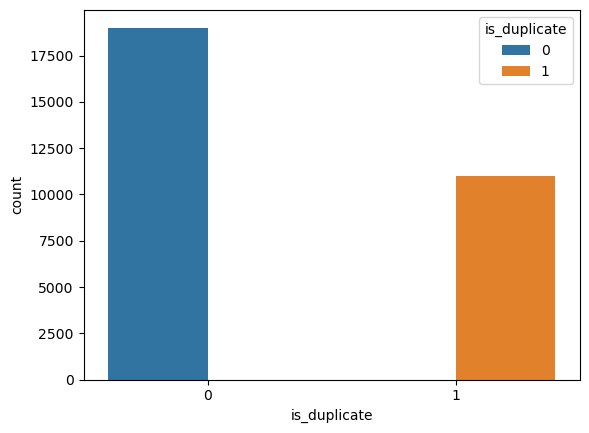

<Figure size 1200x800 with 0 Axes>

In [22]:
# plotting the dyplicate and non-duplicate questions
sns.countplot(x='is_duplicate',data=df,hue = df["is_duplicate"])
plt.figure(figsize=(12,8))
plt.show()

In [23]:
# Repeated questions
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 55299
Number of questions getting repeated 3480


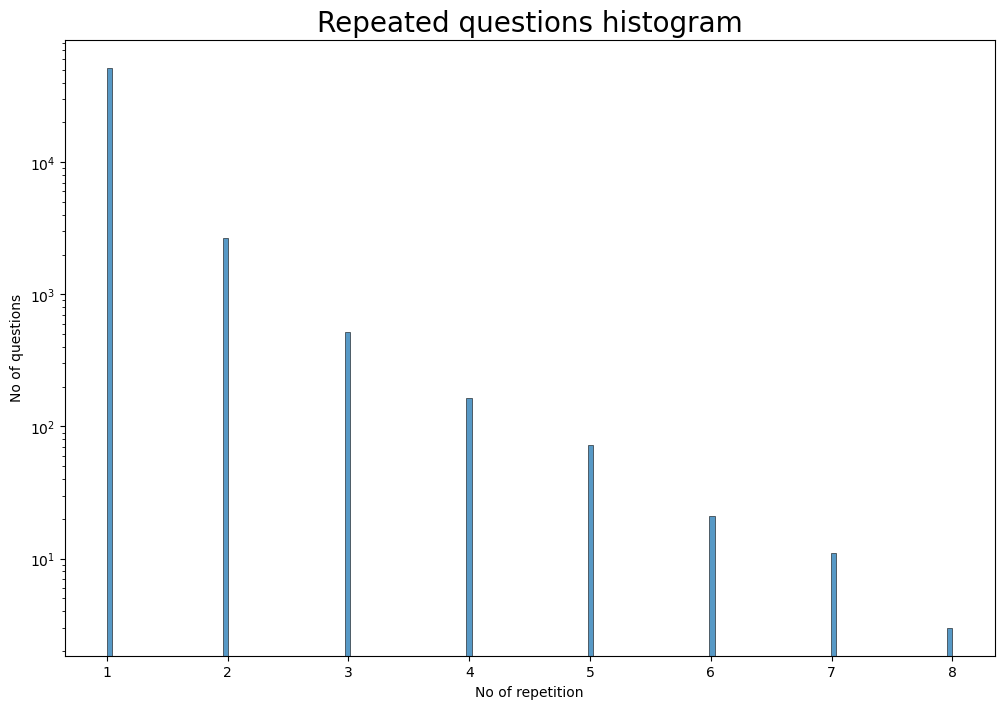

In [24]:
# Repeated questions histogram
plt.figure(figsize=(12,8))
sns.histplot(qid.value_counts().values,bins=160)
plt.title("Repeated questions histogram", size=20)
plt.xlabel("No of repetition")
plt.ylabel("No of questions")
plt.yscale('log')
plt.show()

## Feature Engineering

In [25]:
#grtting the length of each question
df['length_q1']=df['question1'].str.len()
df['length_q2']=df['question2'].str.len()

In [26]:
# getting the number  of word
df['num_words_q1'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['num_words_q2'] = df['question2'].apply(lambda row: len(row.split(" ")))


In [27]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,length_q1,length_q2,num_words_q1,num_words_q2
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,74,75,12,12
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,47,55,12,15
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0,101,115,25,17
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0,56,143,12,30
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9


In [28]:
#common words between question1 and question2
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

df["common_words"] = df.apply(common_words, axis=1)
df.head()
     

,id,qid1,qid2,question1,question2,is_duplicate,length_q1,length_q2,num_words_q1,num_words_q2,common_words
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,74,75,12,12,11
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,47,55,12,15,7
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0,101,115,25,17,2
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0,56,143,12,30,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3


In [29]:
#total number of  words in two questions
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

df['total_words'] = df.apply(total_words, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,length_q1,length_q2,num_words_q1,num_words_q2,common_words,total_words
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,74,75,12,12,11,24
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,47,55,12,15,7,22
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0,101,115,25,17,2,34
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0,56,143,12,30,0,31
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13


In [30]:

#word share
df['word_share'] = round(df['common_words']/df['total_words'],2)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,length_q1,length_q2,num_words_q1,num_words_q2,common_words,total_words,word_share
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,74,75,12,12,11,24,0.46
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,47,55,12,15,7,22,0.32
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0,101,115,25,17,2,34,0.06
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0,56,143,12,30,0,31,0.00
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13,0.23


Maximum character is  391
Minimum character is  2
Average character is  58


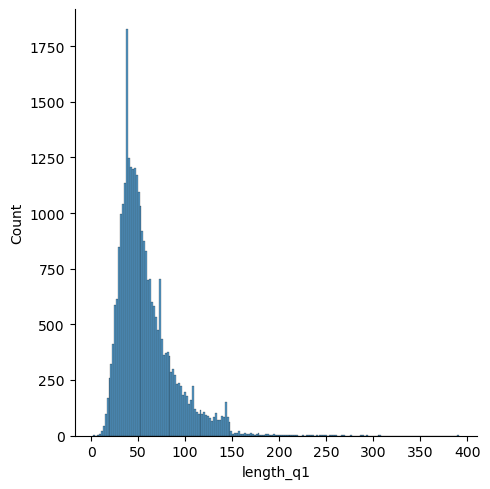

<Figure size 1200x800 with 0 Axes>

In [31]:
sns.displot(df['length_q1'])
print('Maximum character is ',df['length_q1'].max())
print('Minimum character is ',df['length_q1'].min())
print('Average character is ',int(df['length_q1'].mean()))

plt.figure(figsize=(12,8))
plt.show()

Maximum character is  73
Minimum character is  1
Average character is  10


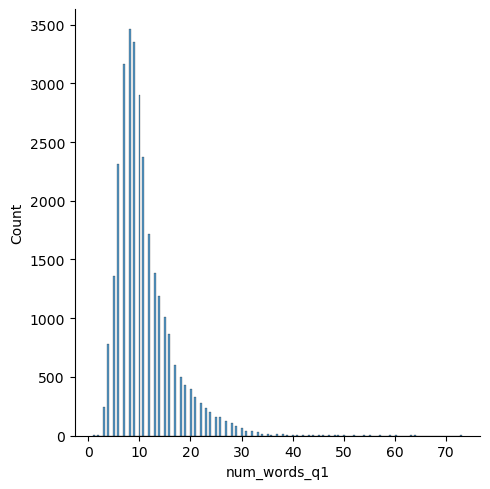

In [32]:
sns.displot(df['num_words_q1'])
print('Maximum character is ',df['num_words_q1'].max())
print('Minimum character is ',df['num_words_q1'].min())
print('Average character is ',int(df['num_words_q1'].mean()))

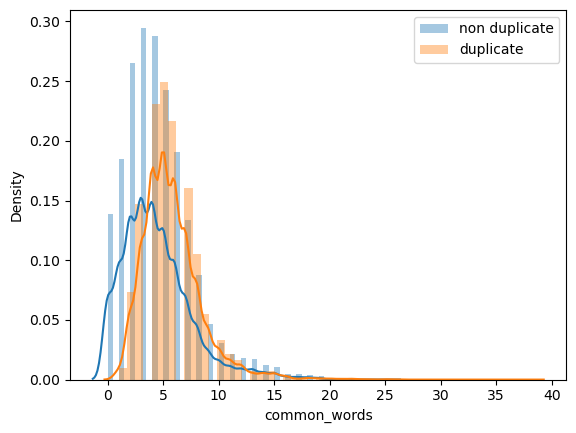

In [33]:
sns.distplot(df[df['is_duplicate'] == 0]['common_words'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['common_words'],label='duplicate')
plt.legend()
plt.show()

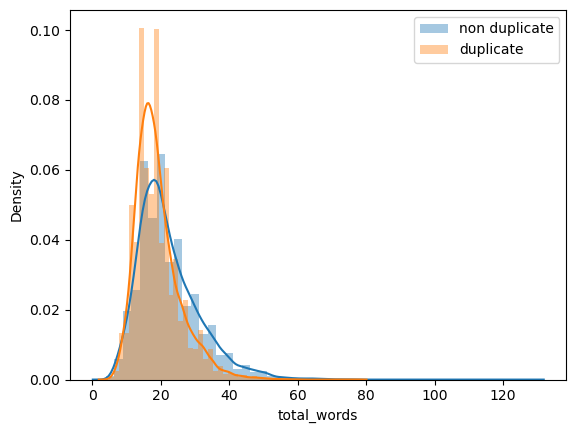

In [34]:
sns.distplot(df[df['is_duplicate'] == 0]['total_words'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['total_words'],label='duplicate')
plt.legend()
plt.show()

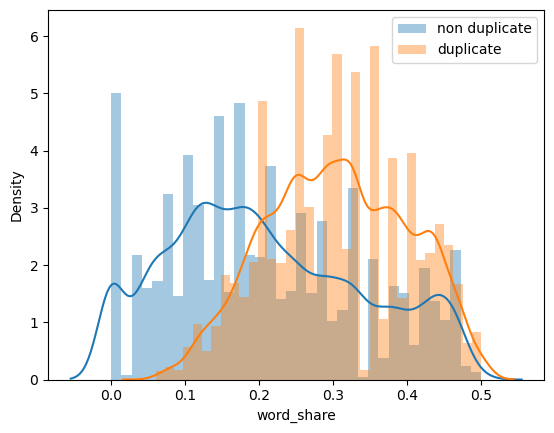

In [35]:
sns.distplot(df[df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

## Advanced Feature

#### 1. Token Features

###### cwc_min: This is the ratio of the number of common words to the length of the smaller question
##### cwc_max: This is the ratio of the number of common words to the length of the larger question
###### csc_min: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
###### csc_max: This is the ratio of the number of common stop words to the larger stop word count among the two questions
###### ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions
###### ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions
###### last_word_eq: 1 if the last word in the two questions is same, 0 otherwise
###### first_word_eq: 1 if the first word in the two questions is same, 0 otherwise

#### 2. Length Based Features

##### mean_len: Mean of the length of the two questions (number of words)
##### abs_len_diff: Absolute difference between the length of the two questions (number of words)

#### 3. Fuzzy Features

###### fuzz_ratio: fuzz_ratio score from fuzzywuzzy
###### fuzz_partial_ratio: fuzz_partial_ratio from fuzzywuzzy
##### token_sort_ratio: token_sort_ratio from fuzzywuzzy
##### token_set_ratio: token_set_ratio from fuzzywuzzy

In [36]:
#token feature
def fetch_token_features(df):
    q1 = df['question1']
    q2 = df['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [37]:
token_features = df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [38]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,length_q1,length_q2,num_words_q1,num_words_q2,...,total_words,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,74,75,12,12,...,24,0.46,0.857131,0.857131,0.999980,0.999980,0.916659,0.916659,1.0,1.0
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,47,55,12,15,...,22,0.32,0.666644,0.499988,0.714276,0.624992,0.583328,0.466664,1.0,1.0
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0,101,115,25,17,...,34,0.06,0.000000,0.000000,0.399992,0.181817,0.117646,0.080000,0.0,0.0
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0,56,143,12,30,...,31,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,13,0.23,0.749981,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,0.0


In [39]:
#length based feature
def fetch_length_features(row):
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*2
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    return length_features
     

In [40]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))

In [41]:
# Fuzzy Features
def fetch_fuzzy_features(row):  
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [42]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

print(df.shape)
df.head()

(30000, 27)


,id,qid1,qid2,question1,question2,is_duplicate,length_q1,length_q2,num_words_q1,num_words_q2,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,74,75,12,12,...,0.916659,0.916659,1.0,1.0,0.0,12.0,99,99,99,99
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,47,55,12,15,...,0.583328,0.466664,1.0,1.0,3.0,13.5,69,66,67,74
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0,101,115,25,17,...,0.117646,0.080000,0.0,0.0,8.0,21.0,42,41,39,44
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0,56,143,12,30,...,0.000000,0.000000,0.0,0.0,18.0,21.0,37,50,37,40
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.599988,0.333330,1.0,0.0,4.0,7.0,60,71,48,69


## Advanced feature analysis

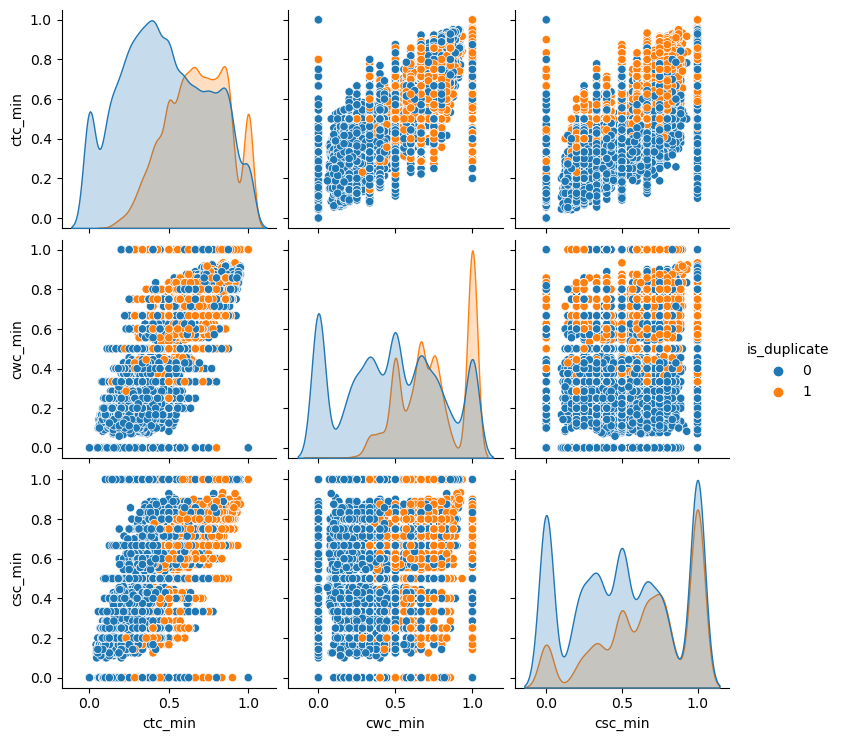

In [43]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')
plt.show()
     

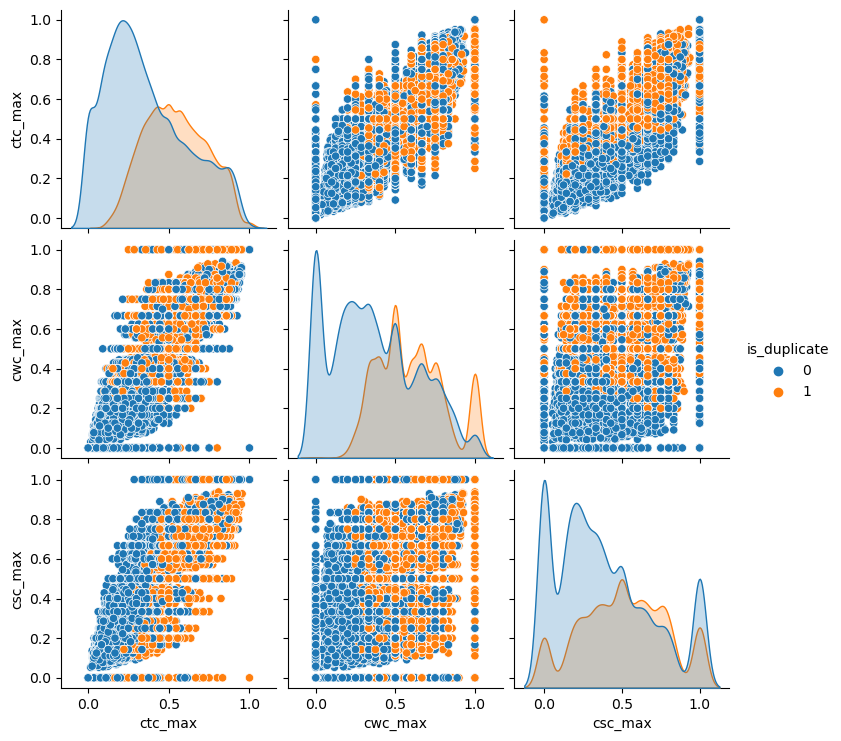

In [44]:
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')
plt.show()

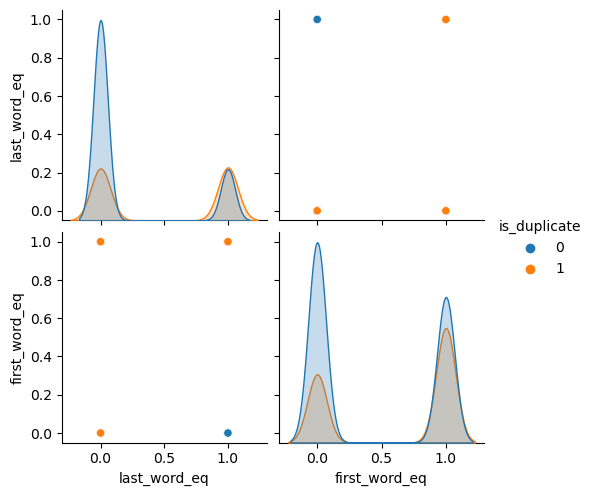

In [45]:
sns.pairplot(df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')
plt.show()

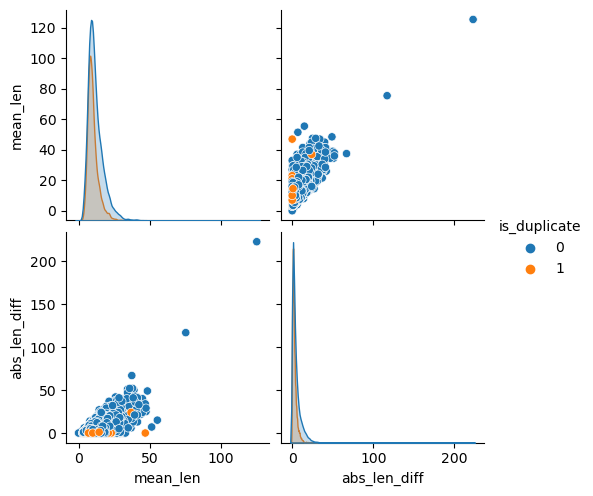

In [46]:
sns.pairplot(df[['mean_len', 'abs_len_diff', 'is_duplicate']],hue='is_duplicate')
plt.show()

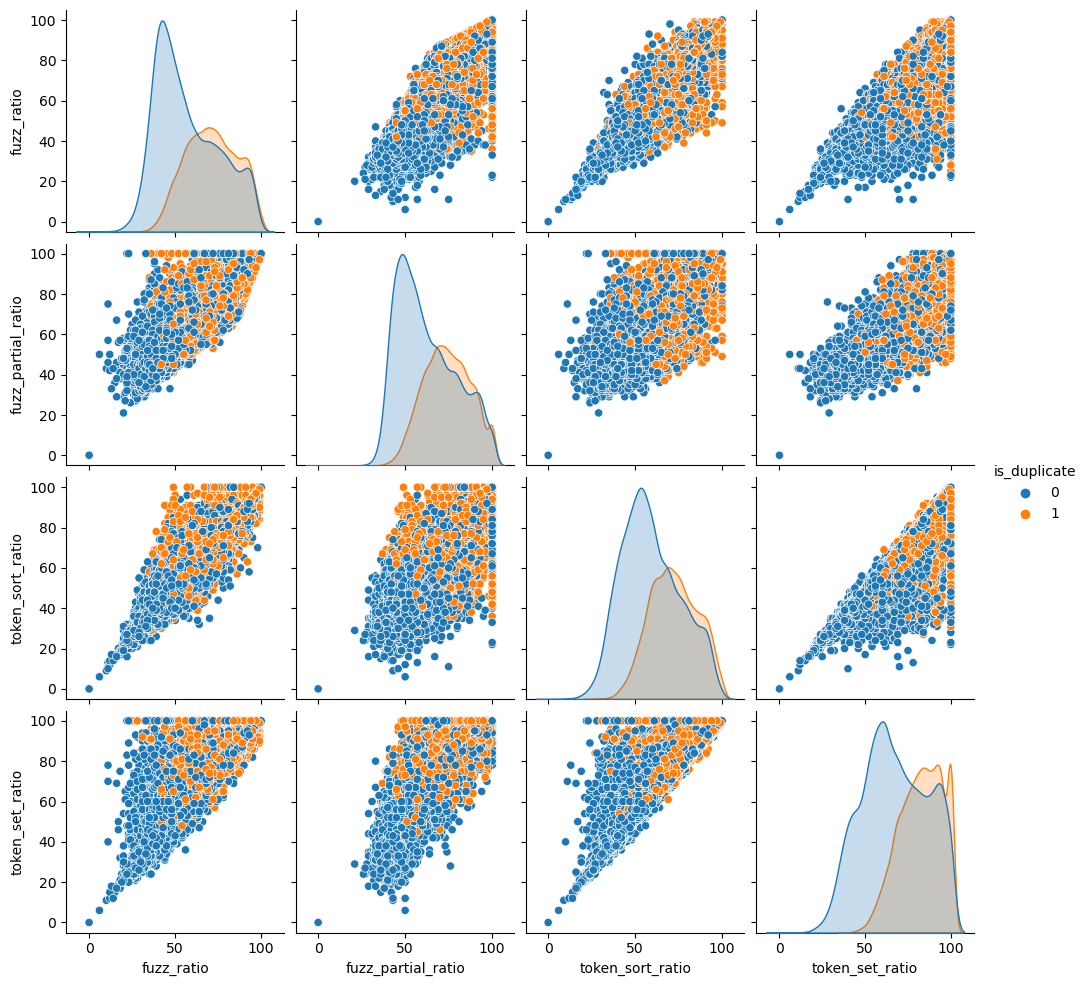

In [47]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio', 'is_duplicate']],hue='is_duplicate')
plt.show()

In [48]:
ques_df = df[['question1','question2']]
ques_df.head()
     

,question1,question2
398782,what is the best marketing automation tool for...,what is the best marketing automation tool for...
115086,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...
327711,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...
367788,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...
151235,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy


In [49]:
final_df = df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(30000, 22)


,is_duplicate,length_q1,length_q2,num_words_q1,num_words_q2,common_words,total_words,word_share,cwc_min,cwc_max,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,1,74,75,12,12,11,24,0.46,0.857131,0.857131,...,0.916659,0.916659,1.0,1.0,0.0,12.0,99,99,99,99
115086,0,47,55,12,15,7,22,0.32,0.666644,0.499988,...,0.583328,0.466664,1.0,1.0,3.0,13.5,69,66,67,74
327711,0,101,115,25,17,2,34,0.06,0.000000,0.000000,...,0.117646,0.080000,0.0,0.0,8.0,21.0,42,41,39,44
367788,0,56,143,12,30,0,31,0.00,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,18.0,21.0,37,50,37,40
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0.599988,0.333330,1.0,0.0,4.0,7.0,60,71,48,69


In [50]:
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=1000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)
     

In [51]:

temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 2000)

In [52]:
#Concat vectorize dataframe with our newly added feature Df
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(30000, 2022)


,is_duplicate,length_q1,length_q2,num_words_q1,num_words_q2,common_words,total_words,word_share,cwc_min,cwc_max,...,990,991,992,993,994,995,996,997,998,999
398782,1,74,75,12,12,11,24,0.46,0.857131,0.857131,...,0,0,0,0,0,0,0,0,0,0
115086,0,47,55,12,15,7,22,0.32,0.666644,0.499988,...,0,0,0,0,0,0,0,0,0,0
327711,0,101,115,25,17,2,34,0.06,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
367788,0,56,143,12,30,0,31,0.00,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0,0,0,0,0,0,0,0,0,0


In [53]:

X = final_df.drop(columns={'is_duplicate'},axis=1)
y=final_df['is_duplicate']

In [54]:
X=X.values
y=y.values

In [55]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=5)

# Testing different models

## Random Forest 

In [56]:
#using random forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy_score(y_pred, y_test)

0.7781666666666667

In [57]:
cf1=confusion_matrix(y_pred,y_test) # for random forest model
print(cf1)

[[3197  763]
 [ 568 1472]]


## XGB

In [58]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.787

In [59]:
cf2=confusion_matrix(y_pred1,y_test) # for XGB model
print(cf2)

[[3156  669]
 [ 609 1566]]


## Logistic Regression

In [60]:
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred2=lr.predict(X_test)
accuracy_score(y_test,y_pred2)

0.725

In [61]:
cf3=confusion_matrix(y_pred2,y_test) # for Logistic_regression model
print(cf3)

[[3093  978]
 [ 672 1257]]


## Support Vector Machine

In [62]:
sv=SVC()
sv.fit(X_train,y_train)
y_pred3=sv.predict(X_test)
accuracy_score(y_test,y_pred3)

0.6936666666666667

In [63]:
cf4=confusion_matrix(y_pred3,y_test) # for Logistic_regression model
print(cf4)

[[2893  966]
 [ 872 1269]]


In [64]:
# Here random forest and XGG perform well as compared to other model

### Hyperparameter tuning on Random Forest

In [65]:
parameter_rf={
    'n_estimators':[10,20,30,40,50,60,70,80,90],
    'criterion':['gini','entropy','log_loss'],
    'max_depth':[1,2,3,4,5,6,7,9,10,13,16,20,23,26,30,34,39,40,45,50,55,60,65,70,75,80,85,90,95,100],
    'max_features':['sqrt','log2','None']
}

In [66]:
rf_cv=RandomizedSearchCV(rf,parameter_rf,cv=5,n_jobs=5,n_iter=20)
rf_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=5,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 9,
                                                      10, 13, 16, 20, 23, 26,
                                                      30, 34, 39, 40, 45, 50,
                                                      55, 60, 65, 70, 75, 80,
                                                      85, 90, 95, 100],
                                        'max_features': ['sqrt', 'log2',
                                                         'None'],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90]})

In [67]:
rf_cv.best_params_

{'n_estimators': 60,
 'max_features': 'sqrt',
 'max_depth': 30,
 'criterion': 'log_loss'}

In [68]:
  # The best parameters are as follow
# n_estimators=70, max_features=sqrt,max_depth=70,criterion=log_loss

In [69]:
# training random forest using hyper parameter tuning
rfc=RandomForestClassifier(n_estimators=70,
                           max_features='sqrt',
                           max_depth=70,
                           criterion='log_loss')

In [70]:
rfc.fit(X_train,y_train)

RandomForestClassifier(criterion='log_loss', max_depth=70, n_estimators=70)

In [71]:
rfc_pred=rfc.predict(X_test)

In [72]:
accuracy_score(y_test,rfc_pred)

0.7815

## Hyperparameter tuning on XGB

In [73]:
params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [15, 20, None], 
    'objective': ['binary:logistic'],
    'eval_metric': ['logloss'],
}


In [74]:
xgbr = XGBClassifier()
clf = RandomizedSearchCV(xgbr, params)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'objective': 'binary:logistic', 'n_estimators': 150, 'max_depth': None, 'eval_metric': 'logloss'}


In [75]:
# the best parameters are as follow
#{'objective': 'binary:logistic', 'n_estimators': 150, 'max_depth': None, 'eval_metric': 'logloss'}


In [76]:
#Training XGBClassifier with the best hyper-parameters
xgbr =XGBClassifier(verbosity = 1, n_estimators = 150, max_depth = None, 
    objective = 'binary:logistic', eval_metric = 'logloss')
xgbr.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [77]:
xgbr_pred=xgbr.predict(X_test)

In [78]:
accuracy_score(y_test,xgbr_pred)

0.7885

In [83]:
#function to return common words for given questions
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

#function to return total words of given questions
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))


#for token features
def test_fetch_token_features(q1,q2): 
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features


#for length features
def test_fetch_length_features(q1,q2):
    length_features = [0.0]*2
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    return length_features


#for fuzzy features
def test_fetch_fuzzy_features(q1,q2):
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features
     

In [84]:
def query_point_creator(q1,q2):
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)

    #decontracted
    q1 = decontracted(q1)
    q2 = decontracted(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()
    
    return np.hstack((np.array(input_query).reshape(1,21),q1_bow,q2_bow))

In [106]:

q1 = 'My name is Dipak Adhikari'
q2 = 'My name is Dipak Adhikari'

In [109]:
a='What is the story of Kohinoor (Koh-i-Noor) Diamond?'
b='What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?'

In [110]:

xgbr.predict(query_point_creator(a,b))

array([0])

In [101]:
cv

CountVectorizer(max_features=1000)

In [105]:
import pickle

pickle.dump(xgbr,open('model.pkl','wb'))
pickle.dump(cv,open('cvs.pkl','wb'))

In [79]:
#import pickle
